In [8]:
import numpy as np
from numpy.random import choice
import random
import tensorflow as tf
from copy import copy, deepcopy

In [1]:
class Board():
    
    def __init__(self, deck):
        
        self.deck = random.sample(deck, 5) # each game only 5 cards are selected from the deck
        self.player = 1
        self.player1_cards = self.deck[:2]
        self.player2_cards = self.deck[2:4]
        self.remaining_card = self.deck[4]
        self.board_size = 5 # 5x5 board
        self.board_2D = np.array([[-1, -1, -2, -1, -1],
                                  [ 0,  0,  0,  0,  0],
                                  [ 0,  0,  0,  0,  0],
                                  [ 0,  0,  0,  0,  0],
                                  [ 1,  1,  2,  1,  1]])
        self.board_state = self.get_board_state()
        self.layer_code = self.get_layer_codes()
        self.layer_decode = {k :v for v,k in self.layer_code.items()}
        
    def get_layer_codes(self):
        """return the 'codes' of each plane of the NN"""
        
        layer_code = {}
        i = 0
        for card in deck:
            for move in card.moves:
                    layer_code[card, move] = i
                    i += 1
        return layer_code
            
    def get_board_state(self):
        """ Return the board state, a 5 x 5 x 10 
        See NNet_architecture to understand the input dimension."""
        
        board_state = np.zeros((self.board_size, self.board_size, 10))
        

        if self.player == 1:
            dict_code = {1 : 0,
                         2 : 1,
                        -1 : 2,
                        -2 : 3}
            
            board_state[:, :, 4] = self.player1_cards[0].map
            board_state[:, :, 5] = self.player1_cards[1].map
            board_state[:, :, 6] = self.player2_cards[0].map
            board_state[:, :, 7] = self.player2_cards[1].map
            board_state[:, :, 9] = np.ones((5, 5)) 

        else:
            dict_code = {1 : 2,
                         2 : 3,
                        -1 : 0,
                        -2 : 1}

            board_state[:, :, 4] = self.player2_cards[0].map
            board_state[:, :, 5] = self.player2_cards[1].map
            board_state[:, :, 6] = self.player1_cards[0].map
            board_state[:, :, 7] = self.player1_cards[1].map
            board_state[:, :, 9] = -np.ones((5, 5)) 
        
        board_state[:, :, 8] = self.remaining_card.map
        for i in range(self.board_size):
            for j in range(self.board_size):
                piece = self.board_2D[i][j]
                if piece in dict_code:
                    board_state[i, j, dict_code[piece]] = 1
        
        return board_state
        
        
    def get_legal_moves(self, policy):
        """Returns all the legal moves for a policy obtained with the neural network """
        
        # transform to positive output
        policy = policy - np.min(policy) # + 1e-9 # may be needed to avoid div by 0 if all element are equals and negatifs
        
        possible_policy = np.zeros((5, 5, 52))
        
        
        player_board2D = self.board_state[:, :, 0] + self.board_state[:, :, 1]
        
        if self.player == 1:
            player_cards = self.player1_cards
        else:
            player_cards = self.player2_cards
       
        # keep only the possible moves, considering the 2 card the player have.
        possibles_moves = set()
        for card in player_cards:
            for move in card.moves:
                possibles_moves.add((card, move))

        for card, (line, column) in possibles_moves:
            for i in range(5):
                for j in range(5):
                    if player_board2D[i][j] != 0 :
                        if (0 <= i + line < 5) and (0 <= j + column < 5):

                            possible_policy[i + line, j +  column , self.layer_code[card, (line, column)]] = policy[i + line, j + column, self.layer_code[card, (line, column)]]
                            
        # The illegal moves are the one where there is already an ally piece on the board
        # we can perform element wise multiplication for each plane to get the legal moves
        for k in range(possible_policy.shape[2]):
            possible_policy[:, :, k] = tf.multiply(possible_policy[:, :, k], (1 - player_board2D))
            
        # Then we normalize to [0, 1]
        possible_policy = possible_policy / np.sum(possible_policy)
        return possible_policy


    
    def move(self, action):
    
        # create the next state
        cls = self.__class__
        next_state = cls.__new__(cls)
        next_state.board_size = self.board_size
        next_state.layer_code = self.layer_code
        next_state.layer_decode = self.layer_decode
        next_state.player = self.player * (-1)
        
        
        # find the piece to move in the board
        plane = action % 52
        column = action // 52 % 5
        line = action // 52 // 5
        
        card, (x, y) = self.layer_decode[plane]
        
        piece_to_move = (line - x, column - y)
        
        # move the piece
        next_state.board_2D = copy(self.board_2D)
        next_state.board_2D[line, column] = self.board_2D[piece_to_move]
        next_state.board_2D[piece_to_move] = 0 
        
        # turn the board to face the new current player
        next_state.board_2D = np.rot90(np.rot90(next_state.board_2D)) 
        
        # Play the move and exchange the played card against the remaining one.
        if self.player == 1:

            next_state.remaining_card = card
            next_state.player2_cards = self.player2_cards
            
            if self.player1_cards[0] == card:
                next_state.player1_cards = [self.player1_cards[1], self.remaining_card]
            else:
                next_state.player1_cards = [self.player1_cards[0], self.remaining_card]
                
        else:
            
            next_state.remaining_card = card
            next_state.player1_cards = self.player1_cards
            
            if self.player2_cards[0] == card:
                next_state.player2_cards = [self.player2_cards[1], self.remaining_card]
            else:
                next_state.player2_cards = [self.player2_cards[0], self.remaining_card]


        next_state.board_state = next_state.get_board_state()
                       
        return next_state
    
    def is_game_over(self):
        """check if the game is over"""
        
        # if a king managed to reach it's opposite case, don't forget the board is facing the current player
        if self.player == 1:
            if self.board_2D[4][2] == -2:
                return True
            if self.board_2D[0][2] == 2:
                return True
        else:
            if self.board_2D[4][2] == 2:
                return True
            if self.board_2D[0][2] == -2:
                return True

        king1_alive = True
        king2_alive = True
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board_2D[i][j] == 2:
                    king1_alive = False
                if self.board_2D[i][j] == -2:
                    king2_alive = False
                    
        return king1_alive or king2_alive
    

    def get_reward_for_player(self):
        if self.is_game_over():
            return -1 
            #return self.player # return 1 if player 1 win, -1 if he lose
        else :
            return None

In [13]:
# %run deck.ipynb
# %run NNet_architecture.ipynb

In [4]:
# root = Board(deck)

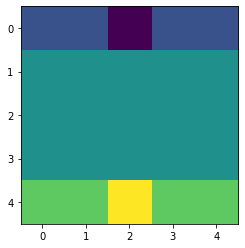

False


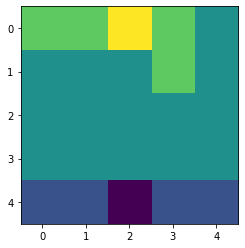

In [40]:
# plt.imshow(root.board_2D)
# plt.show()
# for i in range(1):
#     possible_policy = root.get_legal_moves(policy[0])
#     action = choice(len(possible_policy.flatten()), 1,
#                   p=possible_policy.flatten())[0]
#     root = root.move(action)
#     print(root.is_game_over())
#     plt.imshow(root.board_2D)
#     plt.show()